# Lyrics sentiment analysis

In [1]:
!pip install spacy pandas seaborn

In [2]:
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(palette="Blues_r", style="white")

## Loading the data

We are gonna use the [musiXmatch Dataset](http://millionsongdataset.com/musixmatch/), which consists of 779k lyrics in a bag-of-word format. Additional information can be gathered by looking up the ID in the [Million Song Dataset](http://millionsongdataset.com/).

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
cd gdrive/MyDrive/mxm

/content/gdrive/MyDrive/mxm


Load train and test lyrics data

In [10]:
# Line looks like this track_id, mxm track id, w_id1:wc1, w_id2: wc2, ...
# TRAAAAV128F421A322,4623710,1:6,2:4,...

train_file_path = "mxm_dataset_train.txt"
test_file_path = "mxm_dataset_test.txt"

def word_counts_to_dict(words):
  res = {}
  for word_with_count in words:
    word, count = word_with_count.split(":")
    res[word] = int(count)
  return res

def load_lyrics_word_bag(file_path):
  with open(file_path) as file:
    res = []
    for line in file.readlines():
      # skip comment or top words line
      if line.startswith("#") or line.startswith("%"):
        continue
      track_id_msd, track_id_mxm, *words = line.split(",")
      res.append({"track_id_msd": track_id_msd.strip(), "track_id_mxm": track_id_mxm.strip(), "word_counts": word_counts_to_dict(words)})
    return res

train = load_lyrics_word_bag(train_file_path)
test = load_lyrics_word_bag(test_file_path)

Load additional information

In [11]:
# Million Song Dataset
msd_df = None

msd_file_path = "mxm_779k_matches.txt"


# Format
#     #    -> comment, ignore
#     tid|artist name|title|mxm tid|artist_name|title
#        tid          -> Million Song Dataset track ID
#        artist name  -> artist name in the MSD
#        title        -> title in the MSD
#        mxm tid      -> musiXmatch track ID
#        artist name  -> artist name for mXm
#        title        -> title for mXm
#        |            -> actual separator: <SEP>
# TRMMMKD128F425225D<SEP>Karkkiautomaatti<SEP>Tanssi vaan<SEP>4418550<SEP>Karkkiautomaatti<SEP>Tanssi vaan

with open(msd_file_path) as file:
  res = []
  for line in file.readlines():
    # skip comments
    if line.startswith("#"):
      continue
    track_id_msd, artist_name_msd, title_msd, track_id_mxm, artist_name_mxm, title_mxm = line.split("<SEP>")
    res.append({"track_id_msd": track_id_msd.strip(), "artist_name_msd": artist_name_msd.strip(), "title_msd": title_msd.strip(), 
                "track_id_mxm": track_id_mxm.strip(), "artist_name_mxm": artist_name_mxm.strip(),})
  msd_df = pd.DataFrame(res)


Add genre information

In [12]:
genre_df = None

# FORMAT: # - denotes a comment
#          % - one line after comments, column names
#            - rest is data, comma-separated, one line per song
# %genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
# classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames 


genre_file_path = "msd_genre_dataset.txt"

with open(genre_file_path) as file:
  res = []
  for line in file.readlines():
    # skip comments and description
    # Since line 10 starts with - but is still description, we also need to skip it
    if line.startswith("#") or line.strip().startswith("%") or line.strip().startswith("-"):
      continue
    genre, track_id_msd, *_ = line.split(",")
    res.append({"track_id_msd": track_id_msd.strip(), "genre": genre})
  genre_df = pd.DataFrame(res)

Merge them

In [13]:
# Add validation so each song gets a genre assigned
msd_genre_df = pd.merge(msd_df, genre_df, validate="one_to_many")

In [14]:
msd_genre_df.head()

,track_id_msd,artist_name_msd,title_msd,track_id_mxm,artist_name_mxm,genre
0,TRMMMUT128F42646E8,Shawn Colvin,(Looking For) The Heart Of Saturday,674743,Shawn Colvin,folk
1,TRMMMGL128F92FD6AB,Clifford T. Ward,Mad About You,6821012,Clifford T. Ward,classic pop and rock
2,TRMMWNY12903CF28D2,Warren Zevon,The Rest of the Night,1576953,Warren Zevon,classic pop and rock
3,TRMMWQU12903CF447F,Diablo Swing Orchestra,Lucy Fears the Morning Star,8859768,Diablo Swing Orchestra,metal
4,TRMMWHJ128F42869B2,The Surfaris,Wipeout,13843656,The Surfaris,classic pop and rock


Check for missing values

In [15]:
msd_genre_df.isna().sum()

track_id_msd       0
artist_name_msd    0
title_msd          0
track_id_mxm       0
artist_name_mxm    0
genre              0
dtype: int64

Take a look at genre distribution

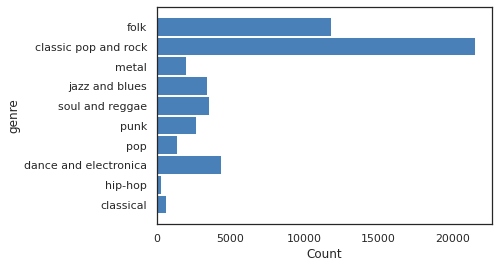

In [26]:
sns.histplot(y=msd_genre_df["genre"])

Calculate doc score for each lyric and cluster them; Let's see if genres are clustered together in general

In [17]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp(lyrics)
filtered_tokens = [token for token in doc if not token.is_stop and not token.is_punct]
lemmas = [token.lemma_ for token in filtered_tokens]